In [32]:
import numpy as np
import matplotlib.pyplot as plt

np.set_printoptions(precision=3, suppress=True)

plt.style.use([
    'grid',
    'science',
    'notebook',
    'high-vis',
])

In [33]:
Ts = 4
iterations = 10001

time = np.arange(0, Ts*iterations, Ts)

r = .31
mu = .40
sigma = .55
A2 = np.pi * r**2

In [34]:
z1_bounds = np.load('./data/z1_bounds.npy')
z2_bounds = np.load('./data/z2_bounds.npy')
z3_bounds = np.load('./data/z3_bounds.npy')

def M1(Z1):
    return (z1_bounds[1] - Z1)/(z1_bounds[1] - z1_bounds[0])

def N1(Z2):
    return (z2_bounds[1] - Z2)/(z2_bounds[1] - z2_bounds[0])

def O1(Z3):
    return (z3_bounds[1] - Z3)/(z3_bounds[1] - z3_bounds[0])

def M2(Z1):
    return 1-M1(Z1)

def N2(Z2):
    return 1-N1(Z2)

def O2(Z3):
    return 1-O1(Z3)

pertinence_functions = np.array([
    [M1, M2],
    [N1, N2],
    [O1, O2]
])

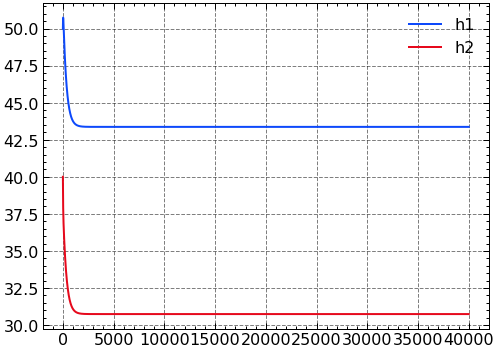

In [35]:
h1_t = np.zeros(iterations)
h2_t = np.zeros(iterations)

m1_t = np.zeros(iterations)
p1_t = np.zeros(iterations)
o1_t = np.zeros(iterations)

h1_0 = 50
h2_0 = 40

h1_t[0] = h1_0
h2_t[0] = h2_0

h1 = h1_0
h2 = h2_0

n = 8

A_matrices = [np.load(f'./data/vertices/A_{i}.npy') for i in range(n)]
B_matrices = [np.load(f'./data/vertices/B_{i}.npy') for i in range(n)]

u = 80

def ds_dt(_, s, Ai, Bi, u):
    _h1, _h2 = s

    h = np.array([
        [_h1],
        [_h2]
    ])

    d_sys = Ai@h + Bi*u

    return d_sys.flatten()


for i in range(1, iterations):
    t = time[i]

    h = np.array([
        [h1],
        [h2]
    ])

    diff = h1 - h2

    R12 = (0.2371*diff+6.9192)*10
    q0  = (18.6367*h2+700.6831)*1e-4
    a1 = (3*r/5)*(2.7*r-((np.cos(2.5*np.pi*(h1-8)*1e-2-mu))/(sigma*np.sqrt(2*np.pi)))*np.exp(-(((h1-8)*1e-2-mu)**2)/(2*sigma**2)))

    Z1 = Ts/R12
    Z2 = (Ts*q0)/h2
    Z3 = 1/a1
    
    v = np.array([
        [pertinence_functions[0, 1](Z1), pertinence_functions[0, 0](Z1)],
        [pertinence_functions[1, 1](Z2), pertinence_functions[1, 0](Z2)],
        [pertinence_functions[2, 1](Z3), pertinence_functions[2, 0](Z3)],
    ])

    m1_t[i] = v[0, 0]
    p1_t[i] = v[1, 0]
    o1_t[i] = v[2, 0]

    weights = np.array([
        v[0, 1] * v[1, 1] * v[2, 1],
        v[0, 1] * v[1, 1] * v[2, 0],
        v[0, 1] * v[1, 0] * v[2, 1],
        v[0, 1] * v[1, 0] * v[2, 0],
        v[0, 0] * v[1, 1] * v[2, 1],
        v[0, 0] * v[1, 1] * v[2, 0],
        v[0, 0] * v[1, 0] * v[2, 1],
        v[0, 0] * v[1, 0] * v[2, 0],
    ])

    Ai = sum([A_matrices[j] * weights[j] for j in range(n)])
    Bi = sum([B_matrices[j] * weights[j] for j in range(n)])

    delta_sys = Ai@h + Bi*u

    h1 = delta_sys[0, 0]
    h2 = delta_sys[1, 0]

    h1_t[i] = h1
    h2_t[i] = h2
    

plt.plot(time, h1_t, '-', label='h1')
plt.plot(time, h2_t, '-', label='h2')
plt.legend()

In [44]:
from scipy.io import savemat

# save m1, p1, o1
savemat('./data/mf.mat', {
    'm1': m1_t,
    'p1': p1_t,
    'o1': o1_t,
})

In [37]:
np.save(f'./data/h3_{Ts}_py.npy', h1_t)
np.save(f'./data/h4_{Ts}_py.npy', h2_t)